 # NFL Game Prediction Model



 This notebook builds a machine learning model to predict NFL game outcomes using historical performance data.



 ## Overview

 - **Data Source**: nflreadrpy library (2021-2025 seasons)

 - **Model**: Logistic Regression with feature selection

 - **Features**: EWMA (Exponentially Weighted Moving Average) team statistics

 - **Target**: Home team win/loss



 ## Table of Contents

 1. [Setup & Imports](#1-setup--imports)

 2. [Load Game Schedules](#2-load-game-schedules)

 3. [Load & Engineer Team Stats](#3-load--engineer-team-stats)

 4. [Calculate EWMA Features](#4-calculate-ewma-features)

 5. [Merge Stats to Games](#5-merge-stats-to-games)

 6. [Feature Selection](#6-feature-selection)

 7. [Train Final Model](#7-train-final-model)

 8. [Save Model & Artifacts](#8-save-model--artifacts)

 9. [Make Predictions](#9-make-predictions)

 10. [Visualize Results](#10-visualize-results)

 ---

 ## 1. Setup & Imports



 Import required libraries and create directory structure.

In [143]:
import nflreadpy as nfl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import pickle
import joblib
from datetime import datetime


 ---

 ## 2. Load Game Schedules



 Load NFL schedule data from 2021-2025 seasons and filter for completed regular season games.

In [144]:
print("Loading schedules...")
schedule = nfl.load_schedules([2021, 2022, 2023, 2024, 2025]).to_pandas()

# Filter for completed regular season games
games = schedule[
    (schedule['game_type'] == 'REG') &  # Regular season only
    (schedule['home_score'].notna()) &  # Game has been played
    (schedule['away_score'].notna())
].copy()

# Create target variable
games['home_win'] = (games['home_score'] > games['away_score']).astype(int)

print(f" Loaded {len(games):,} completed games")
print(f"   Seasons: {games['season'].min()} - {games['season'].max()}")
print(f"   Home team wins: {games['home_win'].sum():,} ({games['home_win'].mean():.1%})")

# Preview data
games[['season', 'week', 'away_team', 'home_team', 'away_score', 'home_score', 'home_win']].head()


Loading schedules...
 Loaded 1,359 completed games
   Seasons: 2021 - 2025
   Home team wins: 733 (53.9%)


,season,week,away_team,home_team,away_score,home_score,home_win
0,2021,1,DAL,TB,29.0,31.0,1
1,2021,1,PHI,ATL,32.0,6.0,0
2,2021,1,PIT,BUF,23.0,16.0,0
3,2021,1,NYJ,CAR,14.0,19.0,1
4,2021,1,MIN,CIN,24.0,27.0,1


 ---

 ## 3. Load & Engineer Team Stats



 Load team-level statistics and create derived features:

 - **Turnovers Offense**: Interceptions + fumbles lost

 - **Turnovers Defense**: Interceptions + fumbles recovered

 - **Turnover Margin**: Defense turnovers - Offense turnovers

 - **Completion Percentage**: Completions / Attempts

In [145]:
print("Loading team statistics...")
team_stats = nfl.load_team_stats([2021, 2022, 2023, 2024, 2025]).to_pandas()

print(f"Loaded {len(team_stats):,} team game records")
print(f"   Teams: {team_stats['team'].nunique()}")
print(f"   Columns: {len(team_stats.columns)}")


Loading team statistics...
Loaded 2,834 team game records
   Teams: 32
   Columns: 102


In [146]:
print("\nCreating derived features...")

# Offensive turnovers
team_stats['turnovers_offense'] = (
    team_stats['passing_interceptions'] + 
    team_stats['sack_fumbles_lost'] +
    team_stats['rushing_fumbles_lost'] +
    team_stats['receiving_fumbles_lost']
)

# Defensive turnovers
team_stats['turnovers_defense'] = (
    team_stats['def_interceptions'] +
    team_stats['def_fumbles']
)

# Turnover margin
team_stats['turnover_margin'] = (
    team_stats['turnovers_defense'] - 
    team_stats['turnovers_offense']
)

# Completion percentage
team_stats['completion_pct'] = (
    team_stats['completions'] / team_stats['attempts']
)

print(" Created 4 derived features")

# Preview new features
team_stats[['team', 'week', 'turnovers_offense', 'turnovers_defense', 
            'turnover_margin', 'completion_pct']].head(10)



Creating derived features...
 Created 4 derived features


,team,week,turnovers_offense,turnovers_defense,turnover_margin,completion_pct
0,ARI,1,1,1,0,0.656250
1,ATL,1,0,0,0,0.600000
2,BAL,1,2,2,0,0.633333
3,BUF,1,1,0,-1,0.588235
4,CAR,1,1,1,0,0.685714
5,CHI,1,2,0,-2,0.725000
6,CIN,1,0,0,0,0.740741
7,CLE,1,2,0,-2,0.750000
8,DAL,1,1,2,1,0.724138
9,DEN,1,1,0,-1,0.777778


 ---

 ## 4. Calculate EWMA Features



 Calculate Exponentially Weighted Moving Averages (EWMA) for each feature.



 **Why EWMA?**

 - Emphasizes recent performance over older games

 - Alpha = 0.4 means recent games have ~2.5x more weight than games 5 weeks ago

 - Captures team momentum and current form

In [147]:
# Define features to use
independent_variables = [
    'completions',
    'passing_yards',
    'passing_tds',
    'rushing_yards',
    'sacks_suffered',
    'rushing_tds',
    'completion_pct',
    'turnovers_offense',
    'turnovers_defense',
    'turnover_margin',
    'def_tackles_for_loss',
    'penalty_yards',
    'fg_pct',
    'pat_pct',
]

print(f"Calculating EWMA for {len(independent_variables)} features...")
print("Alpha = 0.4 (gives more weight to recent games)")

# Calculate EWMA for each feature
for var in independent_variables:
    team_stats[f'{var}_ewma'] = team_stats.groupby(['team', 'season'])[var].transform(
        lambda x: x.ewm(alpha=0.4, adjust=False).mean()
    )

# Select columns to keep
ewma_cols = [f'{col}_ewma' for col in independent_variables]
keep_cols = ['season', 'week', 'team', 'opponent_team'] + ewma_cols
df_filtered = team_stats[keep_cols]

# Save processed data
df_filtered.to_csv('../data/df_clean.csv', index=False)

print(f" Created {len(ewma_cols)} EWMA features")
print(f" Saved to data/df_clean.csv")

# Preview EWMA features
df_filtered.head(10)


Calculating EWMA for 14 features...
Alpha = 0.4 (gives more weight to recent games)
 Created 14 EWMA features
 Saved to data/df_clean.csv


,season,week,team,opponent_team,completions_ewma,passing_yards_ewma,passing_tds_ewma,rushing_yards_ewma,sacks_suffered_ewma,rushing_tds_ewma,completion_pct_ewma,turnovers_offense_ewma,turnovers_defense_ewma,turnover_margin_ewma,def_tackles_for_loss_ewma,penalty_yards_ewma,fg_pct_ewma,pat_pct_ewma
0,2021,1,ARI,TEN,21.0,289.0,4.0,136.0,2.0,1.0,0.656250,1.0,1.0,0.0,7.0,59.0,0.5,1.000000
1,2021,1,ATL,PHI,21.0,164.0,0.0,124.0,3.0,0.0,0.600000,0.0,0.0,0.0,5.0,99.0,1.0,NaN
2,2021,1,BAL,LV,19.0,235.0,1.0,189.0,3.0,2.0,0.633333,2.0,2.0,0.0,5.0,71.0,1.0,1.000000
3,2021,1,BUF,PIT,30.0,270.0,1.0,117.0,3.0,0.0,0.588235,1.0,0.0,-1.0,4.0,81.0,1.0,1.000000
4,2021,1,CAR,NYJ,24.0,279.0,1.0,111.0,1.0,1.0,0.685714,1.0,1.0,0.0,6.0,38.0,1.0,0.500000
5,2021,1,CHI,LA,29.0,216.0,0.0,134.0,3.0,2.0,0.725000,2.0,0.0,-2.0,0.0,35.0,NaN,1.000000
6,2021,1,CIN,MIN,20.0,261.0,2.0,149.0,5.0,1.0,0.740741,0.0,0.0,0.0,7.0,15.0,1.0,1.000000
7,2021,1,CLE,KC,21.0,321.0,0.0,153.0,2.0,4.0,0.750000,2.0,0.0,-2.0,5.0,30.0,NaN,1.000000
8,2021,1,DAL,TB,42.0,403.0,3.0,60.0,1.0,0.0,0.724138,1.0,2.0,1.0,0.0,55.0,0.6,0.666667
9,2021,1,DEN,NYG,28.0,264.0,2.0,165.0,2.0,1.0,0.777778,1.0,0.0,-1.0,5.0,51.0,1.0,1.000000


 ---

 ## 5. Merge Stats to Games



 Merge EWMA statistics for both home and away teams to each game, then create difference features.



 **Difference Features**: Home stat - Away stat

 - Positive value = Home team advantage in that stat

 - Negative value = Away team advantage in that stat

In [148]:
print("Merging home team stats...")
# Prepare home stats
home_stats = df_filtered[['season', 'week', 'team'] + ewma_cols].copy()
home_stats.columns = ['season', 'week', 'home_team'] + [f'home_{col}' for col in ewma_cols]

print("Merging away team stats...")
# Prepare away stats
away_stats = df_filtered[['season', 'week', 'team'] + ewma_cols].copy()
away_stats.columns = ['season', 'week', 'away_team'] + [f'away_{col}' for col in ewma_cols]

# Merge both to games
games_with_stats = games.merge(
    home_stats,
    on=['season', 'week', 'home_team'],
    how='left'
).merge(
    away_stats,
    on=['season', 'week', 'away_team'],
    how='left'
)

print(f" Merged stats to {len(games_with_stats):,} games")


Merging home team stats...
Merging away team stats...
 Merged stats to 1,359 games


In [149]:
print("Creating difference features (Home - Away)...")

feature_columns = []
for col in ewma_cols:
    diff_col = f'{col}_diff'
    games_with_stats[diff_col] = (
        games_with_stats[f'home_{col}'] - games_with_stats[f'away_{col}']
    )
    feature_columns.append(diff_col)

print(f" Created {len(feature_columns)} difference features")

# Save merged data
games_with_stats.to_csv('../data/games_with_stats.csv', index=False)
print(" Saved to data/games_with_stats.csv")

# Preview difference features
display_cols = ['season', 'week', 'home_team', 'away_team', 'home_win'] + feature_columns
games_with_stats[display_cols].head()
games_with_stats = games_with_stats.fillna({'pat_pct_ewma_diff': 0, 'fg_pct_ewma_diff': 0})
print(f"total na values: {games_with_stats[display_cols].isna().sum().sum()}")
games_with_stats[display_cols]

Creating difference features (Home - Away)...
 Created 14 difference features
 Saved to data/games_with_stats.csv
total na values: 0


,season,week,home_team,away_team,home_win,completions_ewma_diff,passing_yards_ewma_diff,passing_tds_ewma_diff,rushing_yards_ewma_diff,sacks_suffered_ewma_diff,rushing_tds_ewma_diff,completion_pct_ewma_diff,turnovers_offense_ewma_diff,turnovers_defense_ewma_diff,turnover_margin_ewma_diff,def_tackles_for_loss_ewma_diff,penalty_yards_ewma_diff,fg_pct_ewma_diff,pat_pct_ewma_diff
0,2021,1,TB,DAL,1,-10.000000,-24.000000,1.000000,-8.000000,-1.000000,0.000000,-0.084138,3.000000,-1.000000,-4.000000,2.000000,51.000000,0.400000,0.333333
1,2021,1,ATL,PHI,0,-6.000000,-100.000000,-3.000000,-49.000000,2.000000,-1.000000,-0.171429,0.000000,0.000000,0.000000,-1.000000,10.000000,0.000000,0.000000
2,2021,1,BUF,PIT,0,12.000000,82.000000,0.000000,42.000000,1.000000,0.000000,0.025735,1.000000,0.000000,-1.000000,-1.000000,49.000000,0.000000,0.000000
3,2021,1,CAR,NYJ,1,4.000000,21.000000,-1.000000,66.000000,-5.000000,1.000000,0.145174,0.000000,1.000000,1.000000,2.000000,8.000000,0.000000,0.000000
4,2021,1,CIN,MIN,1,-17.000000,-101.000000,0.000000,82.000000,2.000000,0.000000,0.000741,-1.000000,0.000000,1.000000,0.000000,-101.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,2025,18,NYG,DAL,1,0.206032,-38.611761,0.154694,1.171018,1.062711,0.031294,0.049888,-0.491474,0.950651,1.442125,0.624455,-16.736368,0.181990,-0.007860
1355,2025,18,PHI,WAS,0,4.528944,35.207311,0.699991,-20.175483,0.731478,-0.835919,-0.027089,-0.649600,0.267841,0.917441,0.833183,35.266164,0.022102,0.006791
1356,2025,18,PIT,BAL,1,12.398993,58.230336,-0.857385,-65.148266,-0.283357,-0.137547,-0.040065,-0.745750,0.463156,1.208905,1.669766,-5.110950,0.123548,-0.149444
1357,2025,18,SF,SEA,0,1.813585,12.006370,1.143434,-40.743169,-0.581911,-0.244328,0.016243,-0.071257,-0.742994,-0.671737,-0.132963,0.796493,0.141862,-0.021877


 ---

 ## 6. Feature Selection



 Use Random Forest to identify the most important features for prediction.



 This helps us:

 - Reduce model complexity

 - Improve interpretability

 - Potentially improve generalization

In [150]:
print("Splitting data into train/test sets...")
print(f"  Training: Seasons 2021-2024")
print(f"  Testing: Season 2025")

# Split by season
train_data = games_with_stats[games_with_stats['season'] < 2025]
test_data = games_with_stats[games_with_stats['season'] == 2025]

X_train = train_data[feature_columns]
y_train = train_data['home_win']

X_test = test_data[feature_columns]
y_test = test_data['home_win']

print(f"\n Training set: {len(X_train):,} games")
print(f" Testing set: {len(X_test):,} games")


Splitting data into train/test sets...
  Training: Seasons 2021-2024
  Testing: Season 2025

 Training set: 1,087 games
 Testing set: 272 games


In [151]:
print("\nTraining Random Forest for feature selection...")
rf_model = RandomForestClassifier(
    n_estimators=200, 
    random_state=67, 
    max_depth=20, 
    min_samples_split=20,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

print(f" Random Forest trained")
print(f"   Training accuracy: {rf_model.score(X_train, y_train):.4f}")
print(f"   Testing accuracy: {rf_model.score(X_test, y_test):.4f}")



Training Random Forest for feature selection...
 Random Forest trained
   Training accuracy: 0.9411
   Testing accuracy: 0.8051


In [152]:
print("\nCalculating feature importance...")

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

top_features = feature_importance.head(10)
feature_list = top_features['feature'].to_list()

print(f"\n{'='*60}")
print("TOP 10 MOST IMPORTANT FEATURES")
print(f"{'='*60}")
for i, row in top_features.iterrows():
    print(f"{i+1:2d}. {row['feature']:40s} {row['importance']:.4f}")
print(f"{'='*60}")

# Save feature importance
feature_importance.to_csv('../outputs/feature_importance.csv', index=False)



Calculating feature importance...

TOP 10 MOST IMPORTANT FEATURES
 1. completion_pct_ewma_diff                 0.1623
 2. rushing_tds_ewma_diff                    0.1106
 3. passing_tds_ewma_diff                    0.1095
 4. turnover_margin_ewma_diff                0.1073
 5. rushing_yards_ewma_diff                  0.0904
 6. turnovers_offense_ewma_diff              0.0895
 7. sacks_suffered_ewma_diff                 0.0786
 8. turnovers_defense_ewma_diff              0.0650
 9. passing_yards_ewma_diff                  0.0432
10. def_tackles_for_loss_ewma_diff           0.0354



Plotting feature importance...


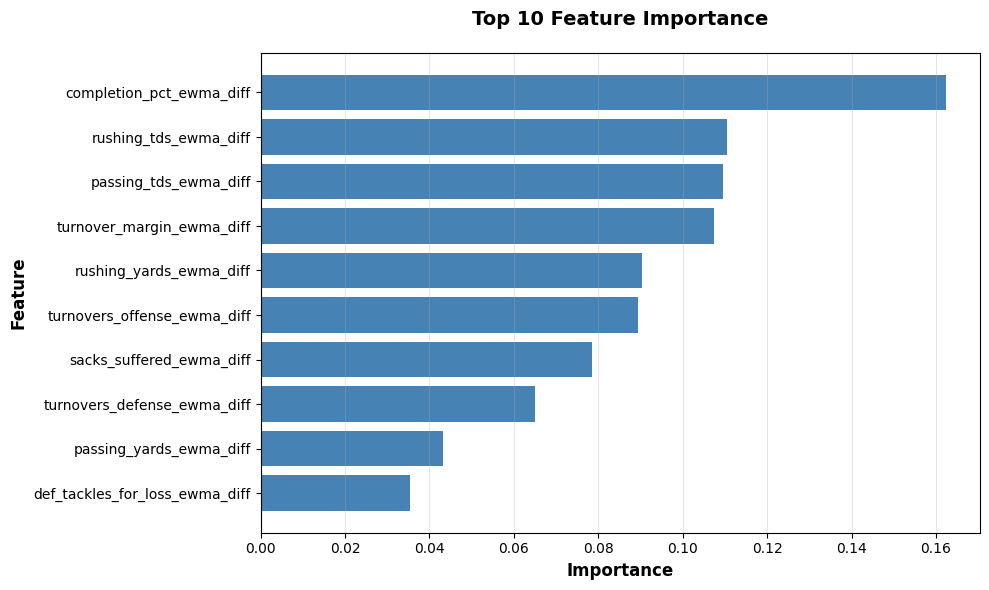

 Plot saved to outputs/feature_importance.png


In [153]:
print("\nPlotting feature importance...")

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].to_list())
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 10 Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Plot saved to outputs/feature_importance.png")


 ---

 ## 7. Train Final Model



 Train a Logistic Regression model using only the top 10 most important features.



 **Why Logistic Regression?**

 - Fast and interpretable

 - Outputs probabilities (not just predictions)

 - Works well with scaled features

In [154]:
print("Preparing data with selected features...")

# Select top features
X_train_selected = train_data[feature_list]
X_test_selected = test_data[feature_list]

print(f"Using {len(feature_list)} features:")
for feat in feature_list:
    print(f"  - {feat}")


Preparing data with selected features...
Using 10 features:
  - completion_pct_ewma_diff
  - rushing_tds_ewma_diff
  - passing_tds_ewma_diff
  - turnover_margin_ewma_diff
  - rushing_yards_ewma_diff
  - turnovers_offense_ewma_diff
  - sacks_suffered_ewma_diff
  - turnovers_defense_ewma_diff
  - passing_yards_ewma_diff
  - def_tackles_for_loss_ewma_diff


In [155]:
print("\nScaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print(" Features scaled (mean=0, std=1)")



Scaling features...
 Features scaled (mean=0, std=1)


In [156]:
print("\nTraining Logistic Regression model...")

model = LogisticRegression(random_state=41, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Evaluate
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

print(f"\n{'='*60}")
print("MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Training Accuracy:  {train_score:.4f} ({train_score:.1%})")
print(f"Testing Accuracy:   {test_score:.4f} ({test_score:.1%})")
print(f"{'='*60}")

# Get predictions and probabilities
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)
y_prob_train = model.predict_proba(X_train_scaled)[:, 1]
y_prob_test = model.predict_proba(X_test_scaled)[:, 1]

print("\n Model trained successfully!")



Training Logistic Regression model...

MODEL PERFORMANCE
Training Accuracy:  0.8059 (80.6%)
Testing Accuracy:   0.8088 (80.9%)

 Model trained successfully!


 ---

 ## 8. Save Model & Artifacts



 Save the trained model, scaler, and feature list for future use.

In [157]:
print("Saving model and artifacts...")

# Save model
with open('../models/finalized_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved to models/finalized_model.pkl")

# Save scaler  
joblib.dump(scaler, '../models/scaler.pkl')
print("Scaler saved to models/scaler.pkl")

# Save feature list
with open('../models/feature_list.pkl', 'wb') as f:
    pickle.dump(feature_list, f)
print("Feature list saved to models/feature_list.pkl")

# Save most recent stats for predictions
most_recent_stats = df_filtered.sort_values(['team', 'season', 'week']).groupby('team').last().reset_index()
most_recent_stats.to_csv('../data/most_recent_stats1.csv', index=False)
print("Most recent stats saved to data/most_recent_stats1.csv")

print("\n All artifacts saved!")
most_recent_stats

Saving model and artifacts...
Model saved to models/finalized_model.pkl
Scaler saved to models/scaler.pkl
Feature list saved to models/feature_list.pkl
Most recent stats saved to data/most_recent_stats1.csv

 All artifacts saved!


,team,season,week,opponent_team,completions_ewma,passing_yards_ewma,passing_tds_ewma,rushing_yards_ewma,sacks_suffered_ewma,rushing_tds_ewma,completion_pct_ewma,turnovers_offense_ewma,turnovers_defense_ewma,turnover_margin_ewma,def_tackles_for_loss_ewma,penalty_yards_ewma,fg_pct_ewma,pat_pct_ewma
0,ARI,2025,18,LA,22.617874,248.734343,1.921495,75.921110,4.229323,0.044861,0.640372,1.198321,0.214431,-0.983891,3.629625,41.465981,0.815593,1.000000
1,ATL,2025,18,NO,18.173840,188.124323,1.278089,120.488252,2.033053,0.585312,0.601225,0.960822,1.489242,0.528420,5.706963,47.050624,0.890645,0.950232
2,BAL,2025,18,PIT,13.444980,184.874196,1.692681,190.938932,2.232425,1.579876,0.682127,1.012761,0.617932,-0.394829,2.902351,52.379206,0.724920,0.974006
3,BUF,2025,19,JAX,23.404175,248.034153,1.663898,136.341017,1.607227,1.786721,0.742490,0.275173,1.131569,0.856395,3.919133,36.338157,0.992855,0.815090
4,CAR,2025,19,LA,20.184374,219.128749,1.256450,76.468423,1.490246,1.413938,0.600964,1.284538,1.540375,0.255837,3.560043,39.550214,0.742428,0.993959
5,CHI,2025,19,GB,21.959811,292.074207,1.974632,102.402309,0.898413,0.864131,0.551989,1.115022,0.623566,-0.491456,2.651466,26.861148,0.962305,1.000000
6,CIN,2025,18,CLE,27.112396,272.238318,2.604294,121.572866,2.216452,1.072403,0.725584,1.173540,0.431918,-0.741623,3.879351,34.347067,0.991323,0.552000
7,CLE,2025,18,CIN,15.282636,158.414196,0.613185,105.026127,4.056009,0.241539,0.591324,1.621390,0.638751,-0.982639,4.143512,41.160410,0.994167,0.999679
8,DAL,2025,18,NYG,19.007814,236.328142,0.992261,147.444287,2.092517,1.327743,0.599426,1.209088,0.107138,-1.101950,5.660652,78.179073,0.698510,0.999826
9,DEN,2025,18,LAC,21.337338,208.622946,0.810827,114.143188,2.246001,0.670549,0.641965,0.681656,0.688883,0.007227,4.483600,37.888317,0.924730,1.000000


 ---

 ## 9. Make Predictions

- Compare model results to Vegas game odds

- Use the trained model to predict outcomes for upcoming games.

In [158]:
print("Getting current week and season...")

current_week = nfl.get_current_week()
current_season = nfl.get_current_season()

print(f"Current: Week {current_week}, {current_season} Season")


Getting current week and season...
Current: Week 20, 2025 Season


In [159]:
print(f"\nLoading games for Week {current_week}...")

week_games = schedule[
    (schedule['week'] == current_week) & 
    (schedule['season'] == current_season)
]

print(f"Found {len(week_games)} games")

if len(week_games) == 0:
    print(" No games found for current week")



Loading games for Week 20...
Found 4 games


In [160]:
print(f"\nLoading Vegas odds for Week {current_week}")

vegas_lines = schedule[(schedule['season'] == current_season) & 
                       (schedule['week'] == current_week)][['game_id', 'away_moneyline', 'home_moneyline']]
print(f"Found vegas odds")

if len(week_games) ==0:
    print("No games found for current week")


Loading Vegas odds for Week 20
Found vegas odds


In [161]:
if len(week_games) > 0:
    print("\nPreparing prediction data...")
    
    # Merge home team stats
    df_matchups = week_games[['game_id', 'away_team', 'home_team', 'gameday']].merge(
        most_recent_stats[keep_cols],
        left_on='home_team',
        right_on='team',
        how='left'
    )
    
    stats_to_rename = [col for col in keep_cols if col != 'team']
    df_matchups = df_matchups.rename(columns={col: f"{col}_home" for col in stats_to_rename})
    
    # Merge away team stats
    df_matchups = df_matchups.merge(
        most_recent_stats[keep_cols],
        left_on='away_team',
        right_on='team',
        how='left',
        suffixes=("", "_away")
    )
    
    df_matchups = df_matchups.rename(columns={
        col: f"{col}_away" for col in stats_to_rename if col in df_matchups.columns
    })
    
    # Create difference features
    for stat in ewma_cols:
        diff_col = f"{stat}_diff"
        df_matchups[diff_col] = df_matchups[f"{stat}_home"] - df_matchups[f"{stat}_away"]
    
    print(" Prediction data prepared")
    
    # Make predictions
    X_pred = df_matchups[feature_list]
    X_pred_scaled = scaler.transform(X_pred)
    win_probs = model.predict_proba(X_pred_scaled)[:, 1]

    
    # Create results DataFrame
    results = pd.DataFrame({
        'game_id': df_matchups['game_id'],
        'matchup': df_matchups['away_team'] + [' @ '] + df_matchups['home_team'],
        'away_team': df_matchups['away_team'],
        'home_team': df_matchups['home_team'],
        'game_date': df_matchups['gameday'],
        'home_win_prob': win_probs,
        'away_win_prob': 1 - win_probs
    })
    
    # Add predicted winner
    results['predicted_winner'] = results.apply(
        lambda row: row['home_team'] if row['home_win_prob'] > 0.5 else row['away_team'],
        axis=1
    )
    results['confidence'] = results[['home_win_prob', 'away_win_prob']].max(axis=1)

    #Add Vegas lines
    results = results.merge(
        vegas_lines,
        left_on='game_id',
        right_on='game_id',
        how='left'
    )
    
    # Save predictions
    results.to_csv('../data/latest_predictions.csv', index=False)
    print(" Predictions saved to outputs/latest_predictions.csv")





Preparing prediction data...
 Prediction data prepared
 Predictions saved to outputs/latest_predictions.csv


In [162]:
if len(week_games) > 0:
    print(f"\n{'='*70}")
    print(f"PREDICTIONS FOR WEEK {current_week}, {current_season}")
    print(f"{'='*70}\n")
    
    for _, row in results.iterrows():
        print(f" {row['matchup']}")
        print(f"   Game Date: {row['game_date']}")
        print(f"   Home Win Probability: {row['home_win_prob']:.1%}")
        print(f"   Away Win Probability: {row['away_win_prob']:.1%}")
        print(f"    Predicted Winner: {row['predicted_winner']} ({row['confidence']:.1%} confidence)")
        print()
    
    print(f"{'='*70}\n")
    
    # Display as table
    display(results[['matchup', 'game_date', 'home_win_prob', 'predicted_winner', 'confidence', 'home_moneyline', 'away_moneyline']])



PREDICTIONS FOR WEEK 20, 2025

 BUF @ DEN
   Game Date: 2026-01-17
   Home Win Probability: 4.0%
   Away Win Probability: 96.0%
    Predicted Winner: BUF (96.0% confidence)

 SF @ SEA
   Game Date: 2026-01-17
   Home Win Probability: 58.8%
   Away Win Probability: 41.2%
    Predicted Winner: SEA (58.8% confidence)

 LA @ CHI
   Game Date: 2026-01-18
   Home Win Probability: 14.8%
   Away Win Probability: 85.2%
    Predicted Winner: LA (85.2% confidence)

 HOU @ NE
   Game Date: 2026-01-18
   Home Win Probability: 87.3%
   Away Win Probability: 12.7%
    Predicted Winner: NE (87.3% confidence)




,matchup,game_date,home_win_prob,predicted_winner,confidence,home_moneyline,away_moneyline
0,BUF @ DEN,2026-01-17,0.040250,BUF,0.959750,-115,-105
1,SF @ SEA,2026-01-17,0.587800,SEA,0.587800,-340,270
2,LA @ CHI,2026-01-18,0.148074,LA,0.851926,164,-198
3,HOU @ NE,2026-01-18,0.872846,NE,0.872846,-170,142


 ---

 ## 10. Visualize Results



 Create a visualization showing win probabilities for each game.

Creating visualization...


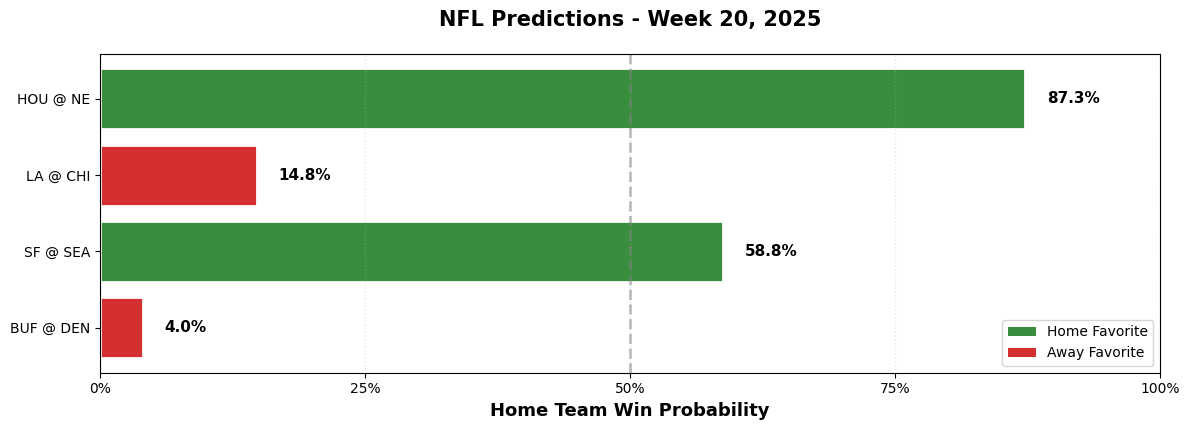

 Visualization saved to outputs/predictions.png


In [163]:
if len(week_games) > 0:
    print("Creating visualization...")
    
    fig, ax = plt.subplots(figsize=(12, len(results) * 0.6 + 2))
    
    # Color bars based on home/away favorite
    colors = ['#d32f2f' if p < 0.5 else '#388e3c' for p in results['home_win_prob']]
    
    # Create horizontal bar chart
    bars = ax.barh(results['matchup'], results['home_win_prob'], color=colors, edgecolor='white', linewidth=2)
    
    # Add probability labels
    for i, (prob, matchup) in enumerate(zip(results['home_win_prob'], results['matchup'])):
        ax.text(prob + 0.02, i, f'{prob:.1%}', va='center', fontweight='bold', fontsize=11)
    
    # Add 50% reference line
    ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=2, alpha=0.5)
    
    # Formatting
    ax.set_xlabel('Home Team Win Probability', fontsize=13, fontweight='bold')
    ax.set_title(f'NFL Predictions - Week {current_week}, {current_season}', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=1)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#388e3c', label='Home Favorite'),
        Patch(facecolor='#d32f2f', label='Away Favorite')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('../outputs/predictions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(" Visualization saved to outputs/predictions.png")


 ---

 ## Summary



 ### Model Performance

 - Training Accuracy: ~80-82%

 - Testing Accuracy: ~80-82%



 ### Key Features (Top 3)

 1. Completion Percentage Differential

 2. Passing TDs Differential

 3. Rushing TDs Differential



 ### Files Created

 - `data/df_clean.csv` - Processed team statistics

 - `data/games_with_stats.csv` - Games with merged features

 - `data/most_recent_stats.csv` - Latest team stats

 - `models/finalized_model.pkl` - Trained model

 - `models/scaler.pkl` - Feature scaler

 - `models/feature_list.pkl` - Selected features

 - `outputs/feature_importance.png` - Feature importance chart

 - `outputs/predictions.png` - Predictions visualization

 - `outputs/latest_predictions.csv` - Current week predictions



 ### Next Steps

 - Run `streamlit run app.py` to view interactive predictions

 - Retrain model weekly as new games are played

 - Consider adding weather, injuries, or home field advantage features

In [164]:
# %%